# 🚀 NASA Exoplanet — AutoML ×3 (AutoGluon, FLAML, PyCaret) with Balancing and Clear Metrics

Notebook inspired by your reference file (**Hanseniase_v2.ipynb**), now applied to **NASA data (Kepler/TESS/KOI/TOI/Exoplanet Archive)** with the following improvements:

* Column merging/normalization to the project’s standard schema
* Cleaning (essential NaNs + outliers via IQR)
* Stratified split
* **AutoML ×3**: **AutoGluon**, **FLAML**, and **PyCaret** (binary classification)
* **Class imbalance handling** (class weights **or** **SMOTE**)
* **Threshold sweep** with a table (FN/FP/Recall/Precision/F1/Specificity/Accuracy)
* **ROC** and **Precision–Recall** curves
* **Listing and export of FNs** (missed positives)

> Edit the **Config** section with your NASA CSVs and the `COLUMN_MAP`.
> Generated on: 2025-10-04 18:49:27

## 0) Instalação (Colab-friendly)

In [ ]:

# Descomente no Colab:
!pip install --no-build-isolation autogluon
!pip install flaml
!pip install pycaret[full]
!pip install imbalanced-learn


  Using cached statsforecast-2.0.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (29 kB)
  Using cached fugue-0.9.1-py3-none-any.whl.metadata (18 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
Using cached fugue-0.9.1-py3-none-any.whl (278 kB)
Using cached statsforecast-2.0.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (353 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 58.2 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144591 sha256=bbf5918f31aad606888b42f034794b5229554d6b058b3ae9679847d02610291a
  Stored in directory: /root/.cache/pip/wheels/1f/be/48/13754633f1d08d1fb

## 1) Robust reading (fixes ParserError)

In [ ]:
import os, json, csv, numpy as np, pandas as pd, matplotlib.pyplot as plt
from functools import reduce

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score, recall_score, precision_score,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
    ConfusionMatrixDisplay
)

# AutoML libs
try:
    from autogluon.tabular import TabularPredictor
    _AG_OK = True
except Exception as e:
    print("AutoGluon indisponível. Instale se quiser usar.", e); _AG_OK = False

try:
    from flaml import AutoML
    _FLAML_OK = True
except Exception as e:
    print("FLAML indisponível. Instale se quiser usar.", e); _FLAML_OK = False

try:
    from pycaret.classification import setup as pc_setup, compare_models, finalize_model, predict_model
    _PYCARET_OK = True
except Exception as e:
    print("PyCaret indisponível. Instale se quiser usar.", e); _PYCARET_OK = False

# Configs
RANDOM_STATE = 42
TEST_SIZE = 0.2
EVAL_METRIC = 'f1'
IMBALANCE_STRATEGY = 'weights'  # 'weights' | 'smote' | None

NASA_FILES = [
    'k2pandc_2025.10.03_15.51.12.csv',
    'cumulative_2025.10.03_16.08.03.csv',
    'TOI_2025.10.03_16.04.34.csv',
]
UNION_MODE = 'concat'  # 'concat' ou 'merge'
MERGE_KEYS = []

READ_PARAMS = {'sep': ',', 'engine': 'python', 'encoding': 'utf-8'}

COLUMN_MAP = {
    'period':                'koi_period',
    'transit_epoch_bjd':     'koi_time0bk',
    'transit_duration_hrs':  'koi_duration',
    'transit_depth_ppm':     'koi_depth',
    'planet_radius_earth':   'koi_prad',
    'star_radius_sol':       'koi_srad',
    'star_teff':             'koi_steff',
    'star_logg':             'koi_slogg',
    'disposition_text':      'koi_disposition',
    'source':                None,
}

POSITIVE_LABELS = ['CONFIRMED', 'CANDIDATE', 'PC', 'CP', 'PUBLISHED CONFIRMED']

MASTER_OUT = 'nasa_master_clean.csv'
REPORT_THR_CSV = 'report_thresholds.csv'
REPORT_FN_CSV  = 'report_false_negatives.csv'

TARGET = 'target_encoded'
DROP_COLS = ['disposition_text', 'source']


PyCaret indisponível. Instale se quiser usar. ('Pycaret only supports python 3.9, 3.10, 3.11. Your actual Python version: ', sys.version_info(major=3, minor=12, micro=11, releaselevel='final', serial=0), 'Please DOWNGRADE your Python version.')


## 2) Normalization → data + target

In [ ]:
HEADER_HINTS = ['koi_', 'kep', 'kepler', 'pl_', 'st_', 'tfopwg', 'tic', 'toi_', 'disposition', 'tfopwg_disp']

def infer_header_row(text, max_lines=200):
    lines = text.splitlines()
    best_idx, best_score = 0, -1
    for i, ln in enumerate(lines[:max_lines]):
        s = sum(h in ln.lower() for h in HEADER_HINTS)
        if s > best_score:
            best_idx, best_score = i, s
    return best_idx

def sniff_sep(text):
    try:
        return csv.Sniffer().sniff(text, delimiters=[',',';','\t','|']).delimiter
    except Exception:
        for cand in [',',';','\t','|']:
            if cand in text: return cand
    return ','

def smart_read_csv(fp, base_params=None, preview_bytes=200_000):
    base_params = base_params or {}
    with open(fp, 'rb') as f:
        sample = f.read(preview_bytes)
    encoding = None
    for enc in ['utf-8', 'latin-1']:
        try:
            text = sample.decode(enc)
            encoding = enc; break
        except UnicodeDecodeError:
            pass
    if encoding is None:
        text = sample.decode('latin-1', errors='replace'); encoding = 'latin-1'
    sep = sniff_sep(text)
    header_row = infer_header_row(text)


    params = dict(
    sep=sep,
    encoding=encoding,
    engine='python',
    on_bad_lines='skip',
    comment='#',
    skiprows=header_row
)

    params.update(base_params or {})
    df = pd.read_csv(fp, **params)
    return df, dict(sep=sep, encoding=encoding, skiprows=header_row)

# Leitura
assert len(NASA_FILES) > 0, "Preencha 'NASA_FILES' com pelo menos um CSV."
dfs, meta_report = [], []
for fp in NASA_FILES:
    try:
        df_i, meta = smart_read_csv(fp, READ_PARAMS)
        dfs.append(df_i)
        meta_report.append({'file': os.path.basename(fp), **meta, 'shape': df_i.shape})
        print(f"✅ {fp} | sep={meta['sep']} enc={meta['encoding']} skip={meta['skiprows']} shape={df_i.shape}")
    except Exception as e:
        print(f"❌ Falha ao ler {fp}: {e}")

if UNION_MODE == 'concat':
    raw = pd.concat(dfs, ignore_index=True)
elif UNION_MODE == 'merge':
    assert len(dfs) >= 2 and MERGE_KEYS, "Para 'merge', forneça >=2 arquivos e MERGE_KEYS."
    raw = reduce(lambda l, r: pd.merge(l, r, on=MERGE_KEYS, how='outer'), dfs)
else:
    raise ValueError("UNION_MODE inválido.")

print("🔹 raw:", raw.shape)


✅ k2pandc_2025.10.03_15.51.12.csv | sep=, enc=utf-8 skip=98 shape=(4004, 95)
✅ cumulative_2025.10.03_16.08.03.csv | sep=, enc=utf-8 skip=7 shape=(9564, 49)
✅ TOI_2025.10.03_16.04.34.csv | sep=, enc=utf-8 skip=69 shape=(7703, 65)
🔹 raw: (21271, 174)


## 3) Cleaning (core NaNs + outliers) → df_final

In [ ]:
def normalize_columns(df, colmap):
    out = pd.DataFrame(index=df.index.copy())
    for std, src in colmap.items():
        out[std] = df[src] if (src and src in df.columns) else np.nan
    return out

data = normalize_columns(raw, COLUMN_MAP)
if 'source' in data.columns and data['source'].isna().all():
    data['source'] = 'NASA'

data[TARGET] = data['disposition_text'].apply(
    lambda x: 1 if pd.notna(x) and str(x).upper() in [p.upper() for p in POSITIVE_LABELS] else 0
)

print("🔹 data:", data.shape, "| positivos:", int((data[TARGET]==1).sum()))
display(data.head(3))


🔹 data: (21271, 11) | positivos: 4725


,period,transit_epoch_bjd,transit_duration_hrs,transit_depth_ppm,planet_radius_earth,star_radius_sol,star_teff,star_logg,disposition_text,source,target_encoded
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NASA,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NASA,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NASA,0


## 4) Split + class weighting for imbalance

In [ ]:
X = df_final[[c for c in df_final.columns if c not in DROP_COLS + [TARGET]]].copy()
y = df_final[TARGET].astype(int).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

train_df = X_train.copy(); train_df[TARGET] = y_train.values
test_df  = X_test.copy();  test_df[TARGET]  = y_test.values

print("Shapes:", train_df.shape, test_df.shape)
print("Balance (train):"); display(train_df[TARGET].value_counts())

# Pesos por classe (simples) -> coluna 'sample_weight'
if IMBALANCE_STRATEGY == 'weights':
    counts = train_df[TARGET].value_counts()
    w_map = (len(train_df) / (2.0*counts)).to_dict()  # balanceia 0 e 1
    train_df['sample_weight'] = train_df[TARGET].map(w_map).astype('float32')
    print("Pesos:", w_map)
else:
    print("Sem pesos explicitos (IMBALANCE_STRATEGY != 'weights').")


Shapes: (3964, 9) (992, 9)
Balance (train):


,count
target_encoded,
1,2765
0,1199


Pesos: {1: 0.7168173598553346, 0: 1.6530442035029191}


## 5) Helper functions (thresholds + reports)

In [ ]:
def _pos_proba(proba):
    # garante vetor 1D da classe positiva
    if isinstance(proba, pd.DataFrame):
        return proba[1].to_numpy() if 1 in proba.columns else proba.iloc[:,-1].to_numpy()
    arr = np.asarray(proba)
    return arr[:, -1] if arr.ndim == 2 else arr

def sweep_thresholds(y_true, proba, thresholds):
    p = _pos_proba(proba); rows = []
    for thr in thresholds:
        y_pred = (p >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        acc  = (tp+tn)/(tp+tn+fp+fn)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        prec = precision_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)
        spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
        rows.append({'threshold':thr,'TP':tp,'FP':fp,'FN':fn,'TN':tn,
                     'FN_rate(%)':100*fn/(tp+fn) if (tp+fn)>0 else 0,
                     'Precision':prec,'Recall':rec,'F1':f1,'Specificity':spec,'Accuracy':acc})
    return pd.DataFrame(rows).sort_values('threshold').reset_index(drop=True)

def best_threshold(y_true, proba, optimize='f1', min_recall=None):
    p = _pos_proba(proba); ts = np.linspace(0.01,0.99,99)
    if min_recall is not None:
        cands = []
        for thr in ts:
            y_pred=(p>=thr).astype(int)
            if recall_score(y_true,y_pred,zero_division=0) >= min_recall:
                cands.append(thr)
        return max(cands) if cands else None
    best_thr, best_score = 0.5, -1
    for thr in ts:
        y_pred=(p>=thr).astype(int)
        score = f1_score(y_true,y_pred,zero_division=0) if optimize=='f1' else recall_score(y_true,y_pred,zero_division=0)
        if score>best_score: best_score, best_thr = score, thr
    return best_thr

def final_reports(y_true, proba, thr, title_prefix=""):
    p = _pos_proba(proba)
    y_pred = (p>=thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"{title_prefix}TP={tp} | FP={fp} | FN={fn} | TN={tn}")
    print(classification_report(y_true, y_pred, digits=3))
    ConfusionMatrixDisplay(confusion_matrix=[[tn,fp],[fn,tp]]).plot()
    plt.title(f"{title_prefix}Matriz de Confusão (thr={thr:.2f})"); plt.show()
    fpr,tpr,_=roc_curve(y_true,p); auc=roc_auc_score(y_true,p)
    plt.figure(); plt.plot(fpr,tpr); plt.plot([0,1],[0,1],'--'); plt.title(f"{title_prefix}ROC (AUC={auc:.3f})"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()
    prec,rec,_=precision_recall_curve(y_true,p); ap=average_precision_score(y_true,p)
    plt.figure(); plt.plot(rec,prec); plt.title(f"{title_prefix}Precision-Recall (AP={ap:.3f})"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.show()


## 6) AutoGluon (com sample_weight no construtor)

No path specified. Models will be saved in: "AutogluonModels/ag-20251004_215642"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Sep  6 09:54:41 UTC 2025
CPU Count:          2
Memory Avail:       9.22 GB / 12.67 GB (72.8%)
Disk Space Avail:   59.60 GB / 107.72 GB (55.3%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optim

+-----------------------------------------------------------+
| Configuration for experiment     NeuralNetFastAI_BAG_L1   |
+-----------------------------------------------------------+
| Search algorithm                 SearchGenerator          |
| Scheduler                        FIFOScheduler            |
| Number of trials                 1000                     |
+-----------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20251004_215642/models/NeuralNetFastAI_BAG_L1


2025-10-04 22:32:26,515	INFO timeout.py:54 -- Reached timeout of 8.879837046424548 seconds. Stopping all trials.
2025-10-04 22:32:26,534	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20251004_215642/models/NeuralNetFastAI_BAG_L1' in 0.0143s.
2025-10-04 22:32:36,588	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- beddba75: FileNotFoundError('Could not fetch metrics for beddba75: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetFastAI_BAG_L1/beddba75')
- 30e75ff9: FileNotFoundError('Could not fetch metrics for 30e75ff9: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetFastAI_BAG_L1/30e75ff9')
No model was trained during hyperparameter tuning NeuralNetFastAI_BAG_L1... Skipping this model.
Hyperparameter tuning model: XGBoost_BAG_L1 ... Tuning model for up to 8.8

Classification metrics can't handle a mix of unknown and binary targets
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/autogluon/core/models/abstract/model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
            ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/autogluon/core/models/abstract/model_trial.py", line 104, in fit_and_save_model
    model.val_score = model.score_with_y_pred_proba(y=fit_args["y"], y_pred_proba=oof_pred_proba)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/autogluon/core/models/abstract/abstract_model.py", line 1376, in score_with_y_pred_proba
    return compute_metric(
           ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/autogluon/core/metrics/score_func.py", line 97, in compute_metric
    return func(y, predictions, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^

+----------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_BAG_L1   |
+----------------------------------------------------------+
| Search algorithm                 SearchGenerator         |
| Scheduler                        FIFOScheduler           |
| Number of trials                 1000                    |
+----------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_BAG_L1


2025-10-04 22:33:18,418	INFO timeout.py:54 -- Reached timeout of 8.879837046424548 seconds. Stopping all trials.
2025-10-04 22:33:18,479	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_BAG_L1' in 0.0458s.
2025-10-04 22:33:26,736	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- 6e25d02b: FileNotFoundError('Could not fetch metrics for 6e25d02b: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_BAG_L1/6e25d02b')
- 458a9350: FileNotFoundError('Could not fetch metrics for 458a9350: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_BAG_L1/458a9350')
No model was trained during hyperparameter tuning NeuralNetTorch_BAG_L1... Skipping this model.
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 8.88s of the 

	0.8109	 = Validation score   (f1)
	45.72s	 = Training   runtime
	0.07s	 = Validation runtime
Hyperparameter tuning model: CatBoost_r177_BAG_L1 ... Tuning model for up to 8.88s of the 1340.85s of remaining time.
	No hyperparameter search space specified for CatBoost_r177_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=4.32%)
Fitted model: CatBoost_r177_BAG_L1 ...
	0.8718	 = Validation score   (f1)
	22.76s	 = Training   runtime
	0.05s	 = Validation runtime
Hyperparameter tuning model: NeuralNetTorch_r79_BAG_L1 ... Tuning model for up to 8.88s of the 1318.06s of remaining time.


+--------------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_r79_BAG_L1   |
+--------------------------------------------------------------+
| Search algorithm                 SearchGenerator             |
| Scheduler                        FIFOScheduler               |
| Number of trials                 1000                        |
+--------------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r79_BAG_L1


2025-10-04 22:34:54,956	INFO timeout.py:54 -- Reached timeout of 8.879837046424548 seconds. Stopping all trials.
2025-10-04 22:34:54,988	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r79_BAG_L1' in 0.0204s.
2025-10-04 22:35:04,443	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- b52d3b77: FileNotFoundError('Could not fetch metrics for b52d3b77: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r79_BAG_L1/b52d3b77')
- 4d4dc9e7: FileNotFoundError('Could not fetch metrics for 4d4dc9e7: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r79_BAG_L1/4d4dc9e7')
No model was trained during hyperparameter tuning NeuralNetTorch_r79_BAG_L1... Skipping this model.
Hyperparameter tuning model: LightGBM_r131_BAG_L1 ... Tuning m

Fitted model: LightGBM_r131_BAG_L1 ...
	0.8773	 = Validation score   (f1)
	39.71s	 = Training   runtime
	0.26s	 = Validation runtime
Hyperparameter tuning model: NeuralNetFastAI_r191_BAG_L1 ... Tuning model for up to 8.88s of the 1259.67s of remaining time.
	No hyperparameter search space specified for NeuralNetFastAI_r191_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.03%)
Fitted model: NeuralNetFastAI_r191_BAG_L1 ...
	0.8547	 = Validation score   (f1)
	43.31s	 = Training   runtime
	0.24s	 = Validation runtime
Hyperparameter tuning model: CatBoost_r9_BAG_L1 ... Tuning model for up to 8.88s of the 1216.32s of remaining time.
	No hyperparameter search space specified for CatBoost_r9_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLoc

+--------------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_r22_BAG_L1   |
+--------------------------------------------------------------+
| Search algorithm                 SearchGenerator             |
| Scheduler                        FIFOScheduler               |
| Number of trials                 1000                        |
+--------------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r22_BAG_L1


2025-10-04 22:37:36,461	INFO timeout.py:54 -- Reached timeout of 8.879837046424548 seconds. Stopping all trials.
2025-10-04 22:37:36,493	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r22_BAG_L1' in 0.0229s.
2025-10-04 22:37:44,426	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- 679eb2dc: FileNotFoundError('Could not fetch metrics for 679eb2dc: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r22_BAG_L1/679eb2dc')
- 635ae106: FileNotFoundError('Could not fetch metrics for 635ae106: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r22_BAG_L1/635ae106')
No model was trained during hyperparameter tuning NeuralNetTorch_r22_BAG_L1... Skipping this model.
Hyperparameter tuning model: XGBoost_r33_BAG_L1 ... Tuning mod

Fitted model: XGBoost_r33_BAG_L1 ...
	0.8721	 = Validation score   (f1)
	21.9s	 = Training   runtime
	0.13s	 = Validation runtime
Hyperparameter tuning model: ExtraTrees_r42_BAG_L1 ... Tuning model for up to 8.88s of the 1117.56s of remaining time.
	No hyperparameter search space specified for ExtraTrees_r42_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTrees_r42_BAG_L1 ...
	0.8907	 = Validation score   (f1)
	3.78s	 = Training   runtime
	0.26s	 = Validation runtime
Hyperparameter tuning model: CatBoost_r137_BAG_L1 ... Tuning model for up to 8.88s of the 1113.73s of remaining time.
	No hyperparameter search space specified for CatBoost_r137_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=4.06%)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages

+--------------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_r30_BAG_L1   |
+--------------------------------------------------------------+
| Search algorithm                 SearchGenerator             |
| Scheduler                        FIFOScheduler               |
| Number of trials                 1000                        |
+--------------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r30_BAG_L1


2025-10-04 22:41:29,480	INFO timeout.py:54 -- Reached timeout of 8.879837046424548 seconds. Stopping all trials.
2025-10-04 22:41:29,535	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r30_BAG_L1' in 0.0407s.
2025-10-04 22:41:39,585	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- 44660564: FileNotFoundError('Could not fetch metrics for 44660564: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r30_BAG_L1/44660564')
- 08c9019d: FileNotFoundError('Could not fetch metrics for 08c9019d: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r30_BAG_L1/08c9019d')
No model was trained during hyperparameter tuning NeuralNetTorch_r30_BAG_L1... Skipping this model.
Hyperparameter tuning model: LightGBM_r130_BAG_L1 ... Tuning m

Fitted model: LightGBM_r130_BAG_L1 ...
	0.8775	 = Validation score   (f1)
	37.09s	 = Training   runtime
	0.19s	 = Validation runtime
Hyperparameter tuning model: NeuralNetTorch_r86_BAG_L1 ... Tuning model for up to 8.88s of the 867.17s of remaining time.


+--------------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_r86_BAG_L1   |
+--------------------------------------------------------------+
| Search algorithm                 SearchGenerator             |
| Scheduler                        FIFOScheduler               |
| Number of trials                 1000                        |
+--------------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r86_BAG_L1


2025-10-04 22:42:25,827	INFO timeout.py:54 -- Reached timeout of 8.879837046424548 seconds. Stopping all trials.
2025-10-04 22:42:25,870	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r86_BAG_L1' in 0.0268s.
2025-10-04 22:42:33,591	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- 72dd3bf9: FileNotFoundError('Could not fetch metrics for 72dd3bf9: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r86_BAG_L1/72dd3bf9')
- 0a111093: FileNotFoundError('Could not fetch metrics for 0a111093: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r86_BAG_L1/0a111093')
No model was trained during hyperparameter tuning NeuralNetTorch_r86_BAG_L1... Skipping this model.
Hyperparameter tuning model: CatBoost_r50_BAG_L1 ... Tuning mo

Fitted model: CatBoost_r50_BAG_L1 ...
	0.8726	 = Validation score   (f1)
	26.09s	 = Training   runtime
	0.16s	 = Validation runtime
Hyperparameter tuning model: NeuralNetFastAI_r11_BAG_L1 ... Tuning model for up to 8.88s of the 824.18s of remaining time.
	No hyperparameter search space specified for NeuralNetFastAI_r11_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.03%)
Fitted model: NeuralNetFastAI_r11_BAG_L1 ...
	0.87	 = Validation score   (f1)
	45.64s	 = Training   runtime
	0.6s	 = Validation runtime
Hyperparameter tuning model: XGBoost_r194_BAG_L1 ... Tuning model for up to 8.88s of the 778.51s of remaining time.
	No hyperparameter search space specified for XGBoost_r194_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldF

+--------------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_r14_BAG_L1   |
+--------------------------------------------------------------+
| Search algorithm                 SearchGenerator             |
| Scheduler                        FIFOScheduler               |
| Number of trials                 1000                        |
+--------------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r14_BAG_L1


2025-10-04 22:45:15,832	INFO timeout.py:54 -- Reached timeout of 8.879837046424548 seconds. Stopping all trials.
2025-10-04 22:45:15,859	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r14_BAG_L1' in 0.0218s.
2025-10-04 22:45:15,868	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- c423baa0: FileNotFoundError('Could not fetch metrics for c423baa0: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r14_BAG_L1/c423baa0')
- 1195dfab: FileNotFoundError('Could not fetch metrics for 1195dfab: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r14_BAG_L1/1195dfab')
No model was trained during hyperparameter tuning NeuralNetTorch_r14_BAG_L1... Skipping this model.
Hyperparameter tuning model: LightGBM_r161_BAG_L1 ... Tuning m

Fitted model: LightGBM_r161_BAG_L1 ...
	0.8731	 = Validation score   (f1)
	36.22s	 = Training   runtime
	0.11s	 = Validation runtime
Hyperparameter tuning model: NeuralNetFastAI_r143_BAG_L1 ... Tuning model for up to 8.88s of the 651.8s of remaining time.
	No hyperparameter search space specified for NeuralNetFastAI_r143_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.03%)
Fitted model: NeuralNetFastAI_r143_BAG_L1 ...
	0.8924	 = Validation score   (f1)
	45.26s	 = Training   runtime
	0.1s	 = Validation runtime
Hyperparameter tuning model: CatBoost_r70_BAG_L1 ... Tuning model for up to 8.88s of the 606.49s of remaining time.
	No hyperparameter search space specified for CatBoost_r70_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocal

+--------------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_r41_BAG_L1   |
+--------------------------------------------------------------+
| Search algorithm                 SearchGenerator             |
| Scheduler                        FIFOScheduler               |
| Number of trials                 1000                        |
+--------------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r41_BAG_L1


2025-10-04 22:49:55,497	INFO timeout.py:54 -- Reached timeout of 8.879837046424548 seconds. Stopping all trials.
2025-10-04 22:49:55,515	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r41_BAG_L1' in 0.0136s.
2025-10-04 22:49:55,953	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- 700db149: FileNotFoundError('Could not fetch metrics for 700db149: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r41_BAG_L1/700db149')
- 3281301d: FileNotFoundError('Could not fetch metrics for 3281301d: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r41_BAG_L1/3281301d')
No model was trained during hyperparameter tuning NeuralNetTorch_r41_BAG_L1... Skipping this model.
Hyperparameter tuning model: XGBoost_r98_BAG_L1 ... Tuning mod

Fitted model: XGBoost_r98_BAG_L1 ...
	0.8664	 = Validation score   (f1)
	22.04s	 = Training   runtime
	0.16s	 = Validation runtime
Hyperparameter tuning model: LightGBM_r15_BAG_L1 ... Tuning model for up to 8.88s of the 385.89s of remaining time.
	No hyperparameter search space specified for LightGBM_r15_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.06%)
Fitted model: LightGBM_r15_BAG_L1 ...
	0.8757	 = Validation score   (f1)
	34.75s	 = Training   runtime
	0.19s	 = Validation runtime
Hyperparameter tuning model: NeuralNetTorch_r158_BAG_L1 ... Tuning model for up to 8.88s of the 351.09s of remaining time.


+---------------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_r158_BAG_L1   |
+---------------------------------------------------------------+
| Search algorithm                 SearchGenerator              |
| Scheduler                        FIFOScheduler                |
| Number of trials                 1000                         |
+---------------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r158_BAG_L1


2025-10-04 22:51:01,968	INFO timeout.py:54 -- Reached timeout of 8.879837046424548 seconds. Stopping all trials.
2025-10-04 22:51:01,992	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r158_BAG_L1' in 0.0127s.
2025-10-04 22:51:11,383	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- 99b87569: FileNotFoundError('Could not fetch metrics for 99b87569: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r158_BAG_L1/99b87569')
- 40948aea: FileNotFoundError('Could not fetch metrics for 40948aea: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r158_BAG_L1/40948aea')
No model was trained during hyperparameter tuning NeuralNetTorch_r158_BAG_L1... Skipping this model.
Hyperparameter tuning model: CatBoost_r86_BAG_L1 ... Tunin

Fitted model: CatBoost_r86_BAG_L1 ...
	0.8731	 = Validation score   (f1)
	24.69s	 = Training   runtime
	0.03s	 = Validation runtime
Hyperparameter tuning model: NeuralNetFastAI_r37_BAG_L1 ... Tuning model for up to 8.88s of the 307.79s of remaining time.
	No hyperparameter search space specified for NeuralNetFastAI_r37_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.03%)
Fitted model: NeuralNetFastAI_r37_BAG_L1 ...
	0.8766	 = Validation score   (f1)
	45.71s	 = Training   runtime
	0.34s	 = Validation runtime
Hyperparameter tuning model: NeuralNetTorch_r197_BAG_L1 ... Tuning model for up to 8.88s of the 262.04s of remaining time.


+---------------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_r197_BAG_L1   |
+---------------------------------------------------------------+
| Search algorithm                 SearchGenerator              |
| Scheduler                        FIFOScheduler                |
| Number of trials                 1000                         |
+---------------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r197_BAG_L1


2025-10-04 22:52:31,029	INFO timeout.py:54 -- Reached timeout of 8.879837046424548 seconds. Stopping all trials.
2025-10-04 22:52:31,068	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r197_BAG_L1' in 0.0282s.
2025-10-04 22:52:38,991	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- 859ca495: FileNotFoundError('Could not fetch metrics for 859ca495: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r197_BAG_L1/859ca495')
- c1c3441f: FileNotFoundError('Could not fetch metrics for c1c3441f: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r197_BAG_L1/c1c3441f')
No model was trained during hyperparameter tuning NeuralNetTorch_r197_BAG_L1... Skipping this model.
Hyperparameter tuning model: CatBoost_r49_BAG_L1 ... Tunin

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/autogluon/core/models/ensemble/bagged_ensemble_model.py", line 1578, in _hyperparameter_tune
    hpo_executor.validate_search_space(search_space, self.name)
  File "/usr/local/lib/python3.12/dist-packages/autogluon/core/hpo/executors.py", line 528, in validate_search_space
    raise EmptySearchSpace
autogluon.core.hpo.exceptions.EmptySearchSpace

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/autogluon/core/models/ensemble/fold_fitting_strategy.py", line 583, in _process_fold_results
    fold_model, pred_proba, time_start_fit, time_end_fit, predict_time, predict_1_time, predict_n_size, fit_num_cpus, fit_num_gpus = self.ray.get(finished)
                                                                                                                                     ^^^^^^^^^^^^^^^^^^^^^^
  File "/us

+---------------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_r143_BAG_L1   |
+---------------------------------------------------------------+
| Search algorithm                 SearchGenerator              |
| Scheduler                        FIFOScheduler                |
| Number of trials                 1000                         |
+---------------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r143_BAG_L1


2025-10-04 22:55:23,096	INFO timeout.py:54 -- Reached timeout of 8.879837046424548 seconds. Stopping all trials.
2025-10-04 22:55:23,158	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r143_BAG_L1' in 0.0507s.
2025-10-04 22:55:33,188	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- 33a4137b: FileNotFoundError('Could not fetch metrics for 33a4137b: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r143_BAG_L1/33a4137b')
- e3b2d516: FileNotFoundError('Could not fetch metrics for e3b2d516: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r143_BAG_L1/e3b2d516')
No model was trained during hyperparameter tuning NeuralNetTorch_r143_BAG_L1... Skipping this model.
Hyperparameter tuning model: CatBoost_r128_BAG_L1 ... Tuni

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/autogluon/core/models/ensemble/bagged_ensemble_model.py", line 1578, in _hyperparameter_tune
    hpo_executor.validate_search_space(search_space, self.name)
  File "/usr/local/lib/python3.12/dist-packages/autogluon/core/hpo/executors.py", line 528, in validate_search_space
    raise EmptySearchSpace
autogluon.core.hpo.exceptions.EmptySearchSpace

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/autogluon/core/models/ensemble/fold_fitting_strategy.py", line 583, in _process_fold_results
    fold_model, pred_proba, time_start_fit, time_end_fit, predict_time, predict_1_time, predict_n_size, fit_num_cpus, fit_num_gpus = self.ray.get(finished)
                                                                                                                                     ^^^^^^^^^^^^^^^^^^^^^^
  File "/us

+--------------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_r31_BAG_L1   |
+--------------------------------------------------------------+
| Search algorithm                 SearchGenerator             |
| Scheduler                        FIFOScheduler               |
| Number of trials                 1000                        |
+--------------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r31_BAG_L1


2025-10-04 22:56:36,255	INFO timeout.py:54 -- Reached timeout of 8.879837046424548 seconds. Stopping all trials.
2025-10-04 22:56:36,271	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r31_BAG_L1' in 0.0118s.
2025-10-04 22:56:45,459	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- 5c1a6e61: FileNotFoundError('Could not fetch metrics for 5c1a6e61: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r31_BAG_L1/5c1a6e61')
- b205bed0: FileNotFoundError('Could not fetch metrics for b205bed0: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r31_BAG_L1/b205bed0')
No model was trained during hyperparameter tuning NeuralNetTorch_r31_BAG_L1... Skipping this model.
Hyperparameter tuning model: ExtraTrees_r4_BAG_L1 ... Tuning m

Fitted model: ExtraTrees_r4_BAG_L1 ...
	0.8676	 = Validation score   (f1)
	3.18s	 = Training   runtime
	0.44s	 = Validation runtime
Hyperparameter tuning model: NeuralNetFastAI_r65_BAG_L1 ... Tuning model for up to 8.88s of the -4.8s of remaining time.
	No hyperparameter search space specified for NeuralNetFastAI_r65_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.04%)
Fitted model: NeuralNetFastAI_r65_BAG_L1 ...
	0.8018	 = Validation score   (f1)
	53.41s	 = Training   runtime
	0.09s	 = Validation runtime
Hyperparameter tuning model: NeuralNetFastAI_r88_BAG_L1 ... Tuning model for up to 8.88s of the -58.29s of remaining time.
	No hyperparameter search space specified for NeuralNetFastAI_r88_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with Par

+--------------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_r87_BAG_L1   |
+--------------------------------------------------------------+
| Search algorithm                 SearchGenerator             |
| Scheduler                        FIFOScheduler               |
| Number of trials                 1000                        |
+--------------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r87_BAG_L1


2025-10-04 22:59:46,930	ERROR worker.py:420 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-10-04 22:59:55,685	INFO timeout.py:54 -- Reached timeout of 8.879837046424548 seconds. Stopping all trials.
2025-10-04 22:59:55,708	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r87_BAG_L1' in 0.0106s.
2025-10-04 23:00:04,910	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- 34c982ec: FileNotFoundError('Could not fetch metrics for 34c982ec: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r87_BAG_L1/34c982ec')
- 0e4eaf44: FileNotFoundError('Could not fetch metrics for 0e4eaf44: both result.json and progress.csv were not found at /content/AutogluonModel


+--------------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_r71_BAG_L1   |
+--------------------------------------------------------------+
| Search algorithm                 SearchGenerator             |
| Scheduler                        FIFOScheduler               |
| Number of trials                 1000                        |
+--------------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r71_BAG_L1


2025-10-04 23:00:14,163	INFO timeout.py:54 -- Reached timeout of 8.879837046424548 seconds. Stopping all trials.
2025-10-04 23:00:14,179	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r71_BAG_L1' in 0.0120s.
2025-10-04 23:00:15,084	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- 00e1db53: FileNotFoundError('Could not fetch metrics for 00e1db53: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r71_BAG_L1/00e1db53')
- ff3c371f: FileNotFoundError('Could not fetch metrics for ff3c371f: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r71_BAG_L1/ff3c371f')
No model was trained during hyperparameter tuning NeuralNetTorch_r71_BAG_L1... Skipping this model.
Hyperparameter tuning model: CatBoost_r143_BAG_L1 ... Tuning m

Fitted model: CatBoost_r143_BAG_L1 ...
	0.8763	 = Validation score   (f1)
	23.55s	 = Training   runtime
	0.02s	 = Validation runtime
Hyperparameter tuning model: ExtraTrees_r178_BAG_L1 ... Tuning model for up to 8.88s of the -234.76s of remaining time.
	No hyperparameter search space specified for ExtraTrees_r178_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTrees_r178_BAG_L1 ...
	0.8806	 = Validation score   (f1)
	2.31s	 = Training   runtime
	0.27s	 = Validation runtime
Hyperparameter tuning model: RandomForest_r166_BAG_L1 ... Tuning model for up to 8.88s of the -237.09s of remaining time.
	No hyperparameter search space specified for RandomForest_r166_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: RandomForest_r166_BAG_L1 ...
	0.8871	 = Validation score   (f1)
	4.94s	 = Training   runtime
	0.36s	 = Validation runtime
Hyperparameter tuning model: XGBoost_r31_BAG_L1 ... Tuning model 

+---------------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_r185_BAG_L1   |
+---------------------------------------------------------------+
| Search algorithm                 SearchGenerator              |
| Scheduler                        FIFOScheduler                |
| Number of trials                 1000                         |
+---------------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r185_BAG_L1


2025-10-04 23:01:18,277	INFO timeout.py:54 -- Reached timeout of 8.879837046424548 seconds. Stopping all trials.
2025-10-04 23:01:18,454	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r185_BAG_L1' in 0.1290s.
2025-10-04 23:01:27,322	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- b879e52e: FileNotFoundError('Could not fetch metrics for b879e52e: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r185_BAG_L1/b879e52e')
- 83184636: FileNotFoundError('Could not fetch metrics for 83184636: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r185_BAG_L1/83184636')
No model was trained during hyperparameter tuning NeuralNetTorch_r185_BAG_L1... Skipping this model.
Hyperparameter tuning model: NeuralNetFastAI_r160_BAG_L1 .

Fitted model: NeuralNetFastAI_r160_BAG_L1 ...
	0.8772	 = Validation score   (f1)
	45.09s	 = Training   runtime
	0.3s	 = Validation runtime
Hyperparameter tuning model: CatBoost_r60_BAG_L1 ... Tuning model for up to 8.88s of the -328.55s of remaining time.
	No hyperparameter search space specified for CatBoost_r60_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=4.27%)
Fitted model: CatBoost_r60_BAG_L1 ...
	0.8708	 = Validation score   (f1)
	27.98s	 = Training   runtime
	0.02s	 = Validation runtime
Hyperparameter tuning model: RandomForest_r15_BAG_L1 ... Tuning model for up to 8.88s of the -356.57s of remaining time.
	No hyperparameter search space specified for RandomForest_r15_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: RandomForest_r15_BAG_L1 ...
	0.8865	 = Validation score   

+--------------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_r76_BAG_L1   |
+--------------------------------------------------------------+
| Search algorithm                 SearchGenerator             |
| Scheduler                        FIFOScheduler               |
| Number of trials                 1000                        |
+--------------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r76_BAG_L1


2025-10-04 23:07:26,681	ERROR worker.py:420 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-10-04 23:07:35,200	INFO timeout.py:54 -- Reached timeout of 8.879837046424548 seconds. Stopping all trials.
2025-10-04 23:07:35,233	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r76_BAG_L1' in 0.0298s.
2025-10-04 23:07:45,260	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- 16475b5a: FileNotFoundError('Could not fetch metrics for 16475b5a: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r76_BAG_L1/16475b5a')
- ee702345: FileNotFoundError('Could not fetch metrics for ee702345: both result.json and progress.csv were not found at /content/AutogluonModel

Fitted model: ExtraTrees_r197_BAG_L1 ...
	0.8895	 = Validation score   (f1)
	3.14s	 = Training   runtime
	0.48s	 = Validation runtime
Hyperparameter tuning model: NeuralNetTorch_r121_BAG_L1 ... Tuning model for up to 8.88s of the -664.53s of remaining time.


+---------------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_r121_BAG_L1   |
+---------------------------------------------------------------+
| Search algorithm                 SearchGenerator              |
| Scheduler                        FIFOScheduler                |
| Number of trials                 1000                         |
+---------------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r121_BAG_L1


2025-10-04 23:07:57,573	INFO timeout.py:54 -- Reached timeout of 8.879837046424548 seconds. Stopping all trials.
2025-10-04 23:07:57,649	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r121_BAG_L1' in 0.0511s.
2025-10-04 23:08:06,566	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- 62023bfb: FileNotFoundError('Could not fetch metrics for 62023bfb: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r121_BAG_L1/62023bfb')
- 01be6a2a: FileNotFoundError('Could not fetch metrics for 01be6a2a: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r121_BAG_L1/01be6a2a')
No model was trained during hyperparameter tuning NeuralNetTorch_r121_BAG_L1... Skipping this model.
Hyperparameter tuning model: NeuralNetFastAI_r127_BAG_L1 .

Fitted model: NeuralNetFastAI_r127_BAG_L1 ...
	0.8858	 = Validation score   (f1)
	49.46s	 = Training   runtime
	0.14s	 = Validation runtime
Hyperparameter tuning model: RandomForest_r16_BAG_L1 ... Tuning model for up to 8.88s of the -732.19s of remaining time.
	No hyperparameter search space specified for RandomForest_r16_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: RandomForest_r16_BAG_L1 ...
	0.8847	 = Validation score   (f1)
	12.36s	 = Training   runtime
	0.33s	 = Validation runtime
Hyperparameter tuning model: NeuralNetFastAI_r194_BAG_L1 ... Tuning model for up to 8.88s of the -744.6s of remaining time.
	No hyperparameter search space specified for NeuralNetFastAI_r194_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.03%)
Fitted model: NeuralNetFastAI_r194_BAG_L1 ...
	0.875

+---------------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_r135_BAG_L1   |
+---------------------------------------------------------------+
| Search algorithm                 SearchGenerator              |
| Scheduler                        FIFOScheduler                |
| Number of trials                 1000                         |
+---------------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r135_BAG_L1


2025-10-04 23:10:28,351	INFO timeout.py:54 -- Reached timeout of 8.879837046424548 seconds. Stopping all trials.
2025-10-04 23:10:28,413	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r135_BAG_L1' in 0.0502s.
2025-10-04 23:10:37,754	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- dc813ca1: FileNotFoundError('Could not fetch metrics for dc813ca1: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r135_BAG_L1/dc813ca1')
- b0110872: FileNotFoundError('Could not fetch metrics for b0110872: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r135_BAG_L1/b0110872')
No model was trained during hyperparameter tuning NeuralNetTorch_r135_BAG_L1... Skipping this model.
Hyperparameter tuning model: NeuralNetFastAI_r4_BAG_L1 ...

Fitted model: NeuralNetFastAI_r4_BAG_L1 ...
	0.8784	 = Validation score   (f1)
	47.26s	 = Training   runtime
	1.09s	 = Validation runtime
Hyperparameter tuning model: ExtraTrees_r126_BAG_L1 ... Tuning model for up to 8.88s of the -881.19s of remaining time.
	No hyperparameter search space specified for ExtraTrees_r126_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTrees_r126_BAG_L1 ...
	0.8745	 = Validation score   (f1)
	2.73s	 = Training   runtime
	0.73s	 = Validation runtime
Hyperparameter tuning model: NeuralNetTorch_r36_BAG_L1 ... Tuning model for up to 8.88s of the -883.99s of remaining time.


+--------------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_r36_BAG_L1   |
+--------------------------------------------------------------+
| Search algorithm                 SearchGenerator             |
| Scheduler                        FIFOScheduler               |
| Number of trials                 1000                        |
+--------------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r36_BAG_L1


2025-10-04 23:11:37,250	INFO timeout.py:54 -- Reached timeout of 8.879837046424548 seconds. Stopping all trials.
2025-10-04 23:11:37,288	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r36_BAG_L1' in 0.0248s.
2025-10-04 23:11:46,663	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- 6719adcb: FileNotFoundError('Could not fetch metrics for 6719adcb: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r36_BAG_L1/6719adcb')
- 8b628697: FileNotFoundError('Could not fetch metrics for 8b628697: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r36_BAG_L1/8b628697')
No model was trained during hyperparameter tuning NeuralNetTorch_r36_BAG_L1... Skipping this model.
Hyperparameter tuning model: NeuralNetFastAI_r100_BAG_L1 ... T

Fitted model: NeuralNetFastAI_r100_BAG_L1 ...
	0.6359	 = Validation score   (f1)
	49.74s	 = Training   runtime
	0.18s	 = Validation runtime
Hyperparameter tuning model: CatBoost_r163_BAG_L1 ... Tuning model for up to 8.88s of the -952.55s of remaining time.
	No hyperparameter search space specified for CatBoost_r163_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=4.31%)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/autogluon/core/models/ensemble/bagged_ensemble_model.py", line 1578, in _hyperparameter_tune
    hpo_executor.validate_search_space(search_space, self.name)
  File "/usr/local/lib/python3.12/dist-packages/autogluon/core/hpo/executors.py", line 528, in validate_search_space
    raise EmptySearchSpace
autogluon.core.hpo.exceptions.EmptySearchSpace

During handling of the above except

+--------------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_r19_BAG_L1   |
+--------------------------------------------------------------+
| Search algorithm                 SearchGenerator             |
| Scheduler                        FIFOScheduler               |
| Number of trials                 1000                        |
+--------------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r19_BAG_L1


2025-10-04 23:13:51,148	INFO timeout.py:54 -- Reached timeout of 8.879837046424548 seconds. Stopping all trials.
2025-10-04 23:13:51,184	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r19_BAG_L1' in 0.0235s.
2025-10-04 23:14:01,231	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- 90d8b6ad: FileNotFoundError('Could not fetch metrics for 90d8b6ad: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r19_BAG_L1/90d8b6ad')
- c58ce016: FileNotFoundError('Could not fetch metrics for c58ce016: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r19_BAG_L1/c58ce016')
No model was trained during hyperparameter tuning NeuralNetTorch_r19_BAG_L1... Skipping this model.
Hyperparameter tuning model: XGBoost_r95_BAG_L1 ... Tuning mod

Fitted model: XGBoost_r95_BAG_L1 ...
	0.8807	 = Validation score   (f1)
	25.69s	 = Training   runtime
	0.12s	 = Validation runtime
Hyperparameter tuning model: XGBoost_r34_BAG_L1 ... Tuning model for up to 8.88s of the -1063.07s of remaining time.
	No hyperparameter search space specified for XGBoost_r34_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.42%)
Fitted model: XGBoost_r34_BAG_L1 ...
	0.871	 = Validation score   (f1)
	24.58s	 = Training   runtime
	0.18s	 = Validation runtime
Hyperparameter tuning model: LightGBM_r42_BAG_L1 ... Tuning model for up to 8.88s of the -1087.69s of remaining time.
	No hyperparameter search space specified for LightGBM_r42_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 w

+-------------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_r1_BAG_L1   |
+-------------------------------------------------------------+
| Search algorithm                 SearchGenerator            |
| Scheduler                        FIFOScheduler              |
| Number of trials                 1000                       |
+-------------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r1_BAG_L1


2025-10-04 23:15:35,174	INFO timeout.py:54 -- Reached timeout of 8.879837046424548 seconds. Stopping all trials.
2025-10-04 23:15:35,198	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r1_BAG_L1' in 0.0127s.
2025-10-04 23:15:35,202	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- 7e37ff36: FileNotFoundError('Could not fetch metrics for 7e37ff36: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r1_BAG_L1/7e37ff36')
- e2b5fc88: FileNotFoundError('Could not fetch metrics for e2b5fc88: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r1_BAG_L1/e2b5fc88')
No model was trained during hyperparameter tuning NeuralNetTorch_r1_BAG_L1... Skipping this model.
Hyperparameter tuning model: NeuralNetTorch_r89_BAG_L1 ... Tuning 


+--------------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_r89_BAG_L1   |
+--------------------------------------------------------------+
| Search algorithm                 SearchGenerator             |
| Scheduler                        FIFOScheduler               |
| Number of trials                 1000                        |
+--------------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r89_BAG_L1


2025-10-04 23:15:44,377	INFO timeout.py:54 -- Reached timeout of 8.879837046424548 seconds. Stopping all trials.
2025-10-04 23:15:44,400	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r89_BAG_L1' in 0.0158s.
2025-10-04 23:15:53,213	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- 55efec48: FileNotFoundError('Could not fetch metrics for 55efec48: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r89_BAG_L1/55efec48')
- a65d1c37: FileNotFoundError('Could not fetch metrics for a65d1c37: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20251004_215642/models/NeuralNetTorch_r89_BAG_L1/a65d1c37')
No model was trained during hyperparameter tuning NeuralNetTorch_r89_BAG_L1... Skipping this model.
Fitting model: WeightedEnsemble_L2 ... Training model for up t

	Ensemble Weights: {'LightGBM_r135_BAG_L1': 0.238, 'XGBoost_r95_BAG_L1': 0.238, 'ExtraTrees_r42_BAG_L1': 0.19, 'CatBoost_r143_BAG_L1': 0.143, 'RandomForestGini_BAG_L1': 0.095, 'NeuralNetFastAI_r172_BAG_L1': 0.095}
	0.8196	 = Validation score   (f1)
	3.76s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting 108 L2 models, fit_strategy="sequential" ...
Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.00s of the -1153.91s of remaining time.
	Ensemble Weights: {'LightGBM_r135_BAG_L1': 0.238, 'XGBoost_r95_BAG_L1': 0.238, 'ExtraTrees_r42_BAG_L1': 0.19, 'CatBoost_r143_BAG_L1': 0.143, 'RandomForestGini_BAG_L1': 0.095, 'NeuralNetFastAI_r172_BAG_L1': 0.095}
	0.8196	 = Validation score   (f1)
	2.75s	 = Training   runtime
	0.01s	 = Validation runtime
AutoGluon training complete, total runtime = 2755.67s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 1165.3 rows/s (793 batch size)
Enabling decision threshold calibration (calibrate_decision_threshold=

📁 AutoGluon path: /content/AutogluonModels/ag-20251004_215642


,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForest_r195_BAG_L1,0.841214,0.886111,f1,0.186986,0.299486,7.709634,0.186986,0.299486,7.709634,1,True,15
1,RandomForest_r39_BAG_L1,0.840473,0.886569,f1,0.245001,0.334600,9.700997,0.245001,0.334600,9.700997,1,True,30
2,RandomForest_r15_BAG_L1,0.839209,0.886475,f1,0.140883,0.409038,7.745776,0.140883,0.409038,7.745776,1,True,55
3,RandomForest_r16_BAG_L1,0.837441,0.884721,f1,0.275381,0.325804,12.358092,0.275381,0.325804,12.358092,1,True,64
4,ExtraTrees_r42_BAG_L1,0.832541,0.890705,f1,0.343736,0.259370,3.777543,0.343736,0.259370,3.777543,1,True,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,LightGBM_r96_BAG_L1,0.768111,0.865443,f1,0.089585,0.068288,38.096897,0.089585,0.068288,38.096897,1,True,10
71,LightGBM_r196_BAG_L1,0.749434,0.837553,f1,0.194065,0.141486,35.630457,0.194065,0.141486,35.630457,1,True,29
72,NeuralNetFastAI_r65_BAG_L1,0.715387,0.801797,f1,0.084133,0.093175,53.413423,0.084133,0.093175,53.413423,1,True,45
73,NeuralNetFastAI_r134_BAG_L1,0.573276,0.674291,f1,0.193936,0.260282,45.648884,0.193936,0.260282,45.648884,1,True,40


,threshold,TP,FP,FN,TN,FN_rate(%),Precision,Recall,F1,Specificity,Accuracy
0,0.05,691,256,1,44,0.144509,0.729673,0.998555,0.843197,0.146667,0.740927
1,0.10,687,208,5,92,0.722543,0.767598,0.992775,0.865784,0.306667,0.785282
2,0.15,685,184,7,116,1.011561,0.788262,0.989884,0.877643,0.386667,0.807460
3,0.20,682,166,10,134,1.445087,0.804245,0.985549,0.885714,0.446667,0.822581
4,0.25,680,146,12,154,1.734104,0.823245,0.982659,0.895916,0.513333,0.840726
5,0.30,674,130,18,170,2.601156,0.838308,0.973988,0.901070,0.566667,0.850806
6,0.35,669,111,23,189,3.323699,0.857692,0.966763,0.908967,0.630000,0.864919
7,0.40,659,105,33,195,4.768786,0.862565,0.952312,0.905220,0.650000,0.860887
8,0.45,651,97,41,203,5.924855,0.870321,0.940751,0.904167,0.676667,0.860887
9,0.50,637,89,55,211,7.947977,0.877410,0.920520,0.898449,0.703333,0.854839


Limiar AutoGluon: {'thr_f1': 0.35000000000000003, 'thr_rec': 0.01, 'thr90': 0.56}
[AutoGluon] TP=669 | FP=111 | FN=23 | TN=189
              precision    recall  f1-score   support

           0      0.892     0.630     0.738       300
           1      0.858     0.967     0.909       692

    accuracy                          0.865       992
   macro avg      0.875     0.798     0.824       992
weighted avg      0.868     0.865     0.857       992



AttributeError: 'list' object has no attribute 'shape'

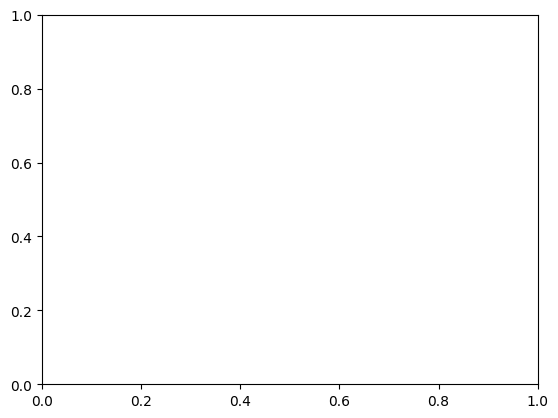

In [ ]:
# =====================================
# ✅ CONFIGURAÇÃO BASE (antes do AutoGluon)
# =====================================
from autogluon.tabular import TabularPredictor
import numpy as np

# Calcula pesos para classes desbalanceadas
if 'sample_weight' not in train_df.columns:
    counts = train_df[TARGET].value_counts()
    w_map = (len(train_df) / (2.0 * counts)).to_dict()
    train_df = train_df.copy()
    train_df['sample_weight'] = train_df[TARGET].map(w_map).astype('float32')
else:
    counts = train_df[TARGET].value_counts()
    w_map = (len(train_df) / (2.0 * counts)).to_dict()

# Replica pesos no conjunto de teste
test_df = test_df.copy()
test_df['sample_weight'] = test_df[TARGET].map(w_map).astype('float32')

# =====================================
# 🚀 AUTOGLUON COM PESOS
# =====================================
if not _AG_OK:
    print("AutoGluon indisponível.")
else:
    ag_predictor = TabularPredictor(
        label=TARGET,
        problem_type='binary',
        eval_metric=EVAL_METRIC,
        sample_weight='sample_weight',
        weight_evaluation=True,
        verbosity=2
    )

    fit_kwargs = dict(
        train_data=train_df,
        presets='best_quality',
        time_limit=3600,
        hyperparameter_tune_kwargs='auto'
    )

    ag_predictor = ag_predictor.fit(**fit_kwargs)

    print("📁 AutoGluon path:", ag_predictor.path)

    # Leaderboard ponderado
    try:
        lb = ag_predictor.leaderboard(test_df, silent=True)
    except Exception as e:
        print("⚠️ leaderboard com pesos falhou, tentando sem pesos:", e)
        lb = ag_predictor.leaderboard(test_df.drop(columns=['sample_weight']), silent=True)
    display(lb)

    # --- Probabilidades e limiares ---
    ag_proba = ag_predictor.predict_proba(test_df.drop(columns=['sample_weight'], errors='ignore'))
    y_true = test_df[TARGET].values

    ag_thr_tbl = sweep_thresholds(y_true, ag_proba, np.linspace(0.05, 0.95, 19))
    display(ag_thr_tbl.head(10))

    thr_f1  = best_threshold(y_true, ag_proba, optimize='f1')
    thr_rec = best_threshold(y_true, ag_proba, optimize='recall')
    thr90   = best_threshold(y_true, ag_proba, min_recall=0.90)

    print("Limiar AutoGluon:", {"thr_f1": thr_f1, "thr_rec": thr_rec, "thr90": thr90})
    THR = thr_f1 if thr_f1 is not None else 0.5

    # --- Relatórios visuais ---
    metrics = final_reports(y_true, ag_proba, THR, title_prefix="[AutoGluon] ")

    # --- Exports úteis ---
    ag_thr_tbl.to_csv(REPORT_THR_CSV, index=False)
    y_pred_exp = (_pos_proba(ag_proba) >= THR).astype(int)
    fn_mask = (test_df[TARGET].values == 1) & (y_pred_exp == 0)
    test_df.loc[fn_mask].to_csv(REPORT_FN_CSV, index=False)

    print(f"✅ Exports salvos:\n - {REPORT_THR_CSV}\n - {REPORT_FN_CSV}")
    print("📈 Métricas resumidas:", metrics)


## 7) AutoML #2 — FLAML

[flaml.automl.logger: 10-04 23:18:32] {1752} INFO - task = classification
[flaml.automl.logger: 10-04 23:18:32] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 10-04 23:18:32] {1862} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 10-04 23:18:32] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost', 'lrl1']
[flaml.automl.logger: 10-04 23:18:32] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 10-04 23:18:32] {2417} INFO - Estimated sufficient time budget=1559s. Estimated necessary time budget=38s.
[flaml.automl.logger: 10-04 23:18:32] {2466} INFO -  at 0.2s,	estimator lgbm's best error=0.2286,	best estimator lgbm's best error=0.2286
[flaml.automl.logger: 10-04 23:18:32] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-04 23:18:32] {2466} INFO -  at 0.3s,	estimator lgbm's best error=0.2286,	best estimator lgbm's best error=0.2286
[flaml.automl.logger:

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 10-04 23:18:32] {2466} INFO -  at 0.6s,	estimator sgd's best error=0.4231,	best estimator lgbm's best error=0.2124
[flaml.automl.logger: 10-04 23:18:32] {2282} INFO - iteration 4, current learner lgbm
[flaml.automl.logger: 10-04 23:18:32] {2466} INFO -  at 0.7s,	estimator lgbm's best error=0.2045,	best estimator lgbm's best error=0.2045
[flaml.automl.logger: 10-04 23:18:32] {2282} INFO - iteration 5, current learner lgbm
[flaml.automl.logger: 10-04 23:18:33] {2466} INFO -  at 0.8s,	estimator lgbm's best error=0.2045,	best estimator lgbm's best error=0.2045
[flaml.automl.logger: 10-04 23:18:33] {2282} INFO - iteration 6, current learner lgbm
[flaml.automl.logger: 10-04 23:18:33] {2466} INFO -  at 1.1s,	estimator lgbm's best error=0.2045,	best estimator lgbm's best error=0.2045
[flaml.automl.logger: 10-04 23:18:33] {2282} INFO - iteration 7, current learner lgbm
[flaml.automl.logger: 10-04 23:18:33] {2466} INFO -  at 1.2s,	estimator lgbm's best error=0.2045,	best es

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 10-04 23:21:25] {2466} INFO -  at 173.2s,	estimator lrl1's best error=0.4030,	best estimator catboost's best error=0.1867
[flaml.automl.logger: 10-04 23:21:25] {2282} INFO - iteration 118, current learner lrl1
[flaml.automl.logger: 10-04 23:21:25] {2466} INFO -  at 173.7s,	estimator lrl1's best error=0.4030,	best estimator catboost's best error=0.1867
[flaml.automl.logger: 10-04 23:21:25] {2282} INFO - iteration 119, current learner catboost
[flaml.automl.logger: 10-04 23:21:35] {2466} INFO -  at 183.6s,	estimator catboost's best error=0.1867,	best estimator catboost's best error=0.1867
[flaml.automl.logger: 10-04 23:21:35] {2282} INFO - iteration 120, current learner lrl1
[flaml.automl.logger: 10-04 23:21:36] {2466} INFO -  at 184.0s,	estimator lrl1's best error=0.4030,	best estimator catboost's best error=0.1867
[flaml.automl.logger: 10-04 23:21:36] {2282} INFO - iteration 121, current learner lrl1
[flaml.automl.logger: 10-04 23:21:36] {2466} INFO -  at 184.7s,	

,threshold,TP,FP,FN,TN,FN_rate(%),Precision,Recall,F1,Specificity,Accuracy
0,0.05,687,218,5,82,0.722543,0.759116,0.992775,0.860363,0.273333,0.775202
1,0.10,685,181,7,119,1.011561,0.790993,0.989884,0.879332,0.396667,0.810484
2,0.15,682,158,10,142,1.445087,0.811905,0.985549,0.890339,0.473333,0.830645
3,0.20,679,142,13,158,1.878613,0.827040,0.981214,0.897555,0.526667,0.843750
4,0.25,672,121,20,179,2.890173,0.847415,0.971098,0.905051,0.596667,0.857863
5,0.30,661,110,31,190,4.479769,0.857328,0.955202,0.903623,0.633333,0.857863
6,0.35,648,96,44,204,6.358382,0.870968,0.936416,0.902507,0.680000,0.858871
7,0.40,638,88,54,212,7.803468,0.878788,0.921965,0.899859,0.706667,0.856855
8,0.45,621,85,71,215,10.260116,0.879603,0.897399,0.888412,0.716667,0.842742
9,0.50,604,74,88,226,12.716763,0.890855,0.872832,0.881752,0.753333,0.836694


Limiar FLAML: {'thr_f1': 0.25, 'thr_rec': 0.01, 'thr90': 0.44}
[FLAML] TP=672 | FP=121 | FN=20 | TN=179
              precision    recall  f1-score   support

           0      0.899     0.597     0.717       300
           1      0.847     0.971     0.905       692

    accuracy                          0.858       992
   macro avg      0.873     0.784     0.811       992
weighted avg      0.863     0.858     0.848       992



AttributeError: 'list' object has no attribute 'shape'

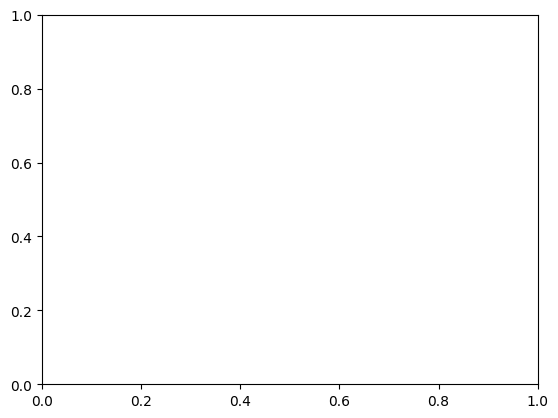

In [ ]:

if not _FLAML_OK:
    print("FLAML indisponível.")
else:
    # FLAML requer X, y separadas
    X_train_f = train_df.drop(columns=[TARGET] + (['sample_weight'] if 'sample_weight' in train_df.columns else []))
    y_train_f = train_df[TARGET].values
    X_test_f  = test_df.drop(columns=[TARGET])
    y_test_f  = test_df[TARGET].values

    automl = AutoML()
    flaml_settings = {
        "time_budget": 3600,
        "metric": EVAL_METRIC,          # 'f1' ou 'recall'
        "task": "classification",
        "log_file_name": "flaml.log",
        "seed": RANDOM_STATE,
    }
    if 'sample_weight' in train_df.columns:
        flaml_settings["sample_weight"] = train_df['sample_weight'].values

    automl.fit(X_train=X_train_f, y_train=y_train_f, **flaml_settings)
    print("FLAML best estimator:", automl.best_estimator)
    print("FLAML best config:", automl.best_config)
    print("FLAML best loss:", automl.best_loss)

    fl_proba = automl.predict_proba(X_test_f)[:,1]
    # Varredura + relatórios
    fl_thr_tbl = sweep_thresholds(y_test_f, fl_proba, np.linspace(0.05, 0.95, 19))
    display(fl_thr_tbl.head(10))

    thr_f1  = best_threshold(y_test_f, fl_proba, optimize='f1')
    thr_rec = best_threshold(y_test_f, fl_proba, optimize='recall')
    thr90   = best_threshold(y_test_f, fl_proba, min_recall=0.90)
    print("Limiar FLAML:", {"thr_f1":thr_f1, "thr_rec":thr_rec, "thr90":thr90})

    THR = thr_f1 if thr_f1 is not None else 0.5
    final_reports(y_test_f, fl_proba, THR, title_prefix="[FLAML] ")


## 8) AutoML #3 — PyCaret

In [ ]:

if not _PYCARET_OK:
    print("PyCaret indisponível.")
else:
    # PyCaret opera em DataFrame completo (features + target)
    train_py = train_df.copy()
    test_py  = test_df.copy()

    # Setup
    clf1 = pc_setup(
        data=train_py, target=TARGET, session_id=RANDOM_STATE,
        silent=True, verbose=False,
        fix_imbalance=(IMBALANCE_STRATEGY=='smote'),  # ativa SMOTE interno se quiser
        use_gpu=False,  # cpu-only por padrão
        fold=5,
        imputation_type='simple'
    )

    # Compara modelos padrão do PyCaret e escolhe o top por F1 (ou mude para 'Recall')
    best = compare_models(sort=EVAL_METRIC)  # 'F1' mapeia para f1; para recall use sort='Recall'
    best = finalize_model(best)

    # Probabilidade no test
    preds = predict_model(best, data=test_py)
    # A coluna 'Score' (se probabilística) pode variar; garantimos a prob positiva:
    if 'Score' in preds.columns:
        py_proba = preds['Score'].values
    else:
        # fallback: gera proba manual se possível
        try:
            py_proba = best.predict_proba(test_py.drop(columns=[TARGET]))[:,1]
        except Exception:
            # se modelo não tiver predict_proba, usa 0/1
            py_proba = preds['Label'].values.astype(float)

    y_true_py = test_py[TARGET].values

    py_thr_tbl = sweep_thresholds(y_true_py, py_proba, np.linspace(0.05, 0.95, 19))
    display(py_thr_tbl.head(10))

    thr_f1  = best_threshold(y_true_py, py_proba, optimize='f1')
    thr_rec = best_threshold(y_true_py, py_proba, optimize='recall')
    thr90   = best_threshold(y_true_py, py_proba, min_recall=0.90)
    print("Limiar PyCaret:", {"thr_f1":thr_f1, "thr_rec":thr_rec, "thr90":thr90})

    THR = thr_f1 if thr_f1 is not None else 0.5
    final_reports(y_true_py, py_proba, THR, title_prefix="[PyCaret] ")


PyCaret indisponível.


## 9) Generic table export (adjust if you want to save per framework)

In [ ]:

# Exemplo: exportar a tabela de limiares do último framework rodado (ajuste conforme desejar)
try:
    thr_table_to_save = py_thr_tbl if 'py_thr_tbl' in globals() else (fl_thr_tbl if 'fl_thr_tbl' in globals() else ag_thr_tbl)
    thr_table_to_save.to_csv('report_thresholds.csv', index=False)
    print("✅ Tabela de limiares exportada para report_thresholds.csv")
except Exception as e:
    print("⚠️ Não foi possível exportar a tabela de limiares:", e)

# Exemplo: exportar FNs do último framework (ajuste)
try:
    THR = thr_f1 if 'thr_f1' in globals() and thr_f1 is not None else 0.5
    # Selecionar y_true/proba da última execução disponível
    if 'y_true_py' in globals() and 'py_proba' in globals():
        y_true_exp, proba_exp, df_base = y_true_py, py_proba, test_df
    elif 'y_test_f' in globals() and 'fl_proba' in globals():
        y_true_exp, proba_exp, df_base = y_test_f, fl_proba, test_df
    else:
        y_true_exp, proba_exp, df_base = y_true, ag_proba, test_df

    y_pred_exp = (proba_exp >= THR).astype(int)
    fn_mask = (df_base[TARGET].values == 1) & (y_pred_exp == 0)
    false_negatives = df_base.loc[fn_mask].copy()
    false_negatives.to_csv('report_false_negatives.csv', index=False)
    print("✅ FNs exportados para report_false_negatives.csv")
except Exception as e:
    print("⚠️ Não foi possível exportar FNs:", e)


✅ Tabela de limiares exportada para report_thresholds.csv
✅ FNs exportados para report_false_negatives.csv
